In [1]:
!pip install emoji
!pip install stop-words
!pip install transformers datasets imblearn seaborn

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,EarlyStoppingCallback,AutoModel
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import emoji
import string
from nltk.corpus import stopwords
from stop_words import get_stop_words
import nltk
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import random
from imblearn.over_sampling import RandomOverSampler

nltk.download('punkt')
nltk.download('stopwords')
tqdm.pandas()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/final-dataset/final_full_data_main.csv')
df

,text,label
0,মেয়েরা উদ্দেশ্য অনুসারে বোবা বোবা আচরণ সুন্দর,1.0
1,গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা সত্যিই পছন্দ করি।...,1.0
2,বাহ ... পাচ্ছি সত্যিই দোষী দোষী সাব্যস্তনোটপ্রেসড,1.0
3,"হাহ, মজার বিষয়।আনোয়েড গ্রুআপ",1.0
4,থান্ডার 830 জেগে উঠলে ভালবাসুন,1.0
...,...,...
8210,बॉलिवुड़ फिल्में देखो। चाहते मुझे रेडिट मैंसेज...,0.0
8211,इनमें बहन भेजा वो पूछेगी कहीं मेरी तबियत खराब,0.0
8212,"“नही, अब बात आ गई क्या मुझे थोड़े रूपये मिल है?""",0.0
8213,**अन्तरजाल स्रोतों** वाचन हिन्दी साहित्य हर दौ...,0.0


In [4]:
label_counts = df['label'].value_counts()
print("Count of tweets with label 1.0 (sarcastic):", label_counts[1.0])
print("Count of tweets with label 0.0 (non-sarcastic):", label_counts[0.0])

Count of tweets with label 1.0 (sarcastic): 1909
Count of tweets with label 0.0 (non-sarcastic): 6306


In [5]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
X_trainf, X_test, y_trainf, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=seed, stratify=df['label']
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainf, y_trainf, test_size=0.1, random_state=seed, stratify=y_trainf
)

X_train = X_train.astype(str)
X_test = X_test.astype(str)
X_valid = X_valid.astype(str)

y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)
y_valid = pd.Series(y_valid).reset_index(drop=True)

In [7]:
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=150):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Balance the training dataset using Oversampling


In [9]:
ros = RandomOverSampler(random_state=seed)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_frame(), y_train)

label_counts12 = y_train_resampled.value_counts()
print("Count of tweets with label 1.0 (sarcastic):", label_counts12[1.0])
print("Count of tweets with label 0.0 (non-sarcastic):", label_counts12[0.0])

X_train_resampled = X_train_resampled['text']

Count of tweets with label 1.0 (sarcastic): 4540
Count of tweets with label 0.0 (non-sarcastic): 4540


In [10]:
train_dataset = SarcasmDataset(
    texts=X_train_resampled.tolist(),
    labels=y_train_resampled.tolist(),
    tokenizer=tokenizer,
)

valid_dataset = SarcasmDataset(
    texts=X_valid.tolist(),
    labels=y_valid.tolist(),
    tokenizer=tokenizer,
)

test_dataset = SarcasmDataset(
    texts=X_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer,
)

# Initialize model for classification


In [11]:
model = AutoModelForSequenceClassification.from_pretrained("ai4bharat/indic-bert", num_labels=2).to(device)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-6,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    seed=seed
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"Train accuracy": accuracy_score(p.label_ids, preds)}

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=compute_metrics
)

# Training the model


In [14]:
train_results = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mudralimbasia (mudralimbasia-usc). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Train accuracy
1,0.669600,0.675949,0.744681
2,0.580400,0.686527,0.731003
3,0.585800,0.619012,0.840426
4,0.422100,0.640123,0.814590
5,0.423400,0.599579,0.838906
6,0.433400,0.561051,0.869301
7,0.525400,0.524768,0.863222
8,0.413400,0.449357,0.864742
9,0.357500,0.445746,0.857143
10,0.295900,0.425129,0.861702


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

# Extracting training and validation losses by epoch


Epoch 1: Training Loss = 0.5804, Validation Loss = 0.6759
Epoch 2: Training Loss = 0.5858, Validation Loss = 0.6865
Epoch 3: Training Loss = 0.4221, Validation Loss = 0.6190
Epoch 4: Training Loss = 0.5383, Validation Loss = 0.6401
Epoch 5: Training Loss = 0.4334, Validation Loss = 0.5996
Epoch 6: Training Loss = 0.5254, Validation Loss = 0.5611
Epoch 7: Training Loss = 0.4134, Validation Loss = 0.5248
Epoch 8: Training Loss = 0.3575, Validation Loss = 0.4494
Epoch 9: Training Loss = 0.4234, Validation Loss = 0.4457
Epoch 10: Training Loss = 0.3089, Validation Loss = 0.4251
Epoch 11: Training Loss = 0.2717, Validation Loss = 0.4373
Epoch 12: Training Loss = 0.2347, Validation Loss = 0.4476


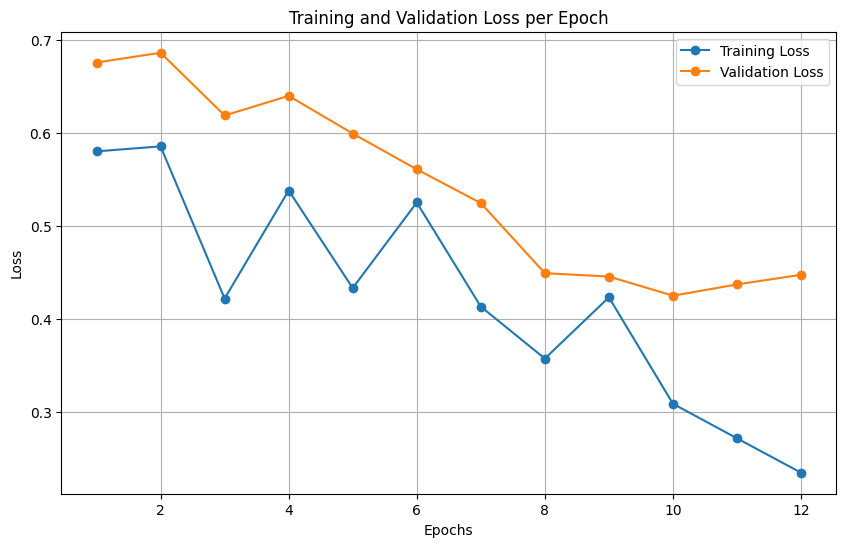

In [15]:
log_history = trainer.state.log_history

epoch_train_losses = {}
epoch_eval_losses = {}

for entry in log_history:
    if 'epoch' in entry:
        epoch = int(entry['epoch'])
        # Record training loss if present (last one encountered per epoch is used)
        if 'loss' in entry:
            epoch_train_losses[epoch] = entry['loss']
        # Record evaluation loss if present
        if 'eval_loss' in entry:
            epoch_eval_losses[epoch] = entry['eval_loss']

# Only consider epochs that have both training and eval losses
common_epochs = sorted(set(epoch_train_losses.keys()) & set(epoch_eval_losses.keys()))
final_train_losses = [epoch_train_losses[e] for e in common_epochs]
final_eval_losses = [epoch_eval_losses[e] for e in common_epochs]

for epoch, (train_loss, eval_loss) in enumerate(zip(final_train_losses, final_eval_losses), start=1):
    print(f"Epoch {epoch}: Training Loss = {train_loss:.4f}, Validation Loss = {eval_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(common_epochs, final_train_losses, label="Training Loss", marker="o")
plt.plot(common_epochs, final_eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

# Final evaluation on the test set


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.8381


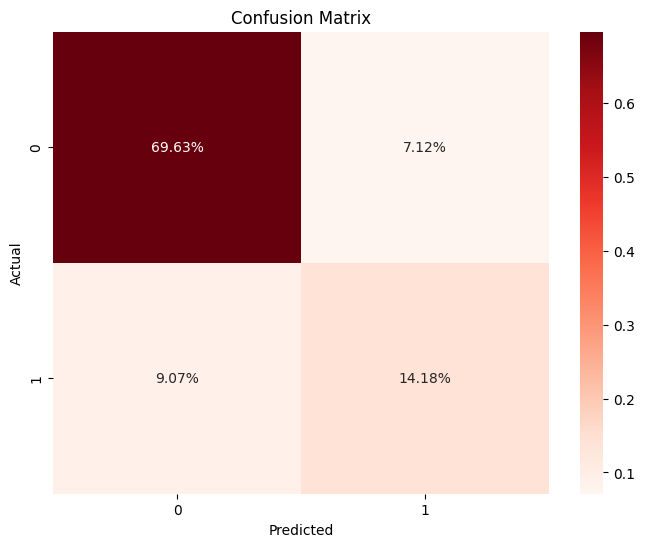

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.91      0.90      1261
         1.0       0.67      0.61      0.64       382

    accuracy                           0.84      1643
   macro avg       0.78      0.76      0.77      1643
weighted avg       0.83      0.84      0.84      1643



In [16]:
test_predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)

# Accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, predicted_labels))